# Training a voice type classifier pipeline from scratch with `pyannote.audio`

Voice type classification (VTC) is the task of detecting where each type of voice is speaking in an audio recording.
For instance, detecting male and female speech.
In this tutorial, you will learn how to train and evaluate a VTC pipeline from scratch.

## Data preparation

TODO :
- ensure that the debug dataset is working, and explain that we're going to use it
- explain the relabeling step and the label derivation step


See [`pyannote.database` documentation](https://github.com/pyannote/pyannote-database#pyannote-database) to learn how to prepare your own dataset for training with `pyannote.audio`.

In [1]:
from typing import Dict, Any, List

from pyannote.database import get_protocol, FileFinder, ProtocolFile
from pyannote.database.protocol.protocol import Preprocessor
from pyannote.database.util import LabelMapper

from pyannote.audio.utils.preprocessors import DeriveMetaLabels

labels = {'FEE078', 'FEE080', 'FEE081', 'FEE083', 'FEE085', 'FEE087', 'FEE088', 'FEO065', 'FEO066', 'FEO070', 'FEO072', 'FEO079', 'MEE009', 'MEE012', 'MEE067', 'MEE068', 'MEE071', 'MEE073', 'MEE075', 'MEE076', 'MEE089', 'MEE094', 'MEE095', 'MEO069', 'MEO074', 'MEO082', 'MEO086'}

label_mapper = LabelMapper({label : ("MALE" if label.startswith("M") else "FEMALE")
                            for label in labels})

labels_derivation = DeriveMetaLabels(classes=["MALE", "FEMALE"],
                                     unions={"SPEECH": ["MALE", "FEMALE"]})


class ProcessorChain:

    def __init__(self, preprocessors: List[Preprocessor], key: str):
        self.procs = preprocessors
        self.key = key

    def __call__(self, file: ProtocolFile):
        file_cp: Dict[str, Any] = abs(file)
        for proc in self.procs:
            out = proc(file_cp)
            file_cp[self.key] = out

        return out


vtc_debug = get_protocol('Debug.SpeakerDiarization.Debug',
                             preprocessors={
                                 "audio": FileFinder(),
                                 "annotation": ProcessorChain([label_mapper, labels_derivation],
                                                              key="annotation")
                             })

/home/htiteux/.conda/envs/pyannote-vtc-v2/lib/python3.8/site-packages/pyannote/database/database.py:51: UserWarning: Ignoring deprecated 'preprocessors' argument in BasalVoice.__init__. Pass it to 'get_protocol' instead.
  warnings.warn(msg)
/home/htiteux/.conda/envs/pyannote-vtc-v2/lib/python3.8/site-packages/pyannote/database/database.py:51: UserWarning: Ignoring deprecated 'preprocessors' argument in VTCDebug.__init__. Pass it to 'get_protocol' instead.
  warnings.warn(msg)
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


`pyannote.database` *protocols* usually define 
* a training set: `for training_file in protocol.train(): ...`, 
* a validation set: `for validation_file in protocol.development(): ...` 
* an evaluation set `for evaluation_file in protocol.test(): ...`

Let's listen to one minute of the first training file...

In [2]:
training_file = list(vtc_debug.train())[8]
reference = training_file["annotation"]

In [3]:
from pyannote.audio.utils.preview import listen

listen(training_file)

... and visualize the manual annotation:

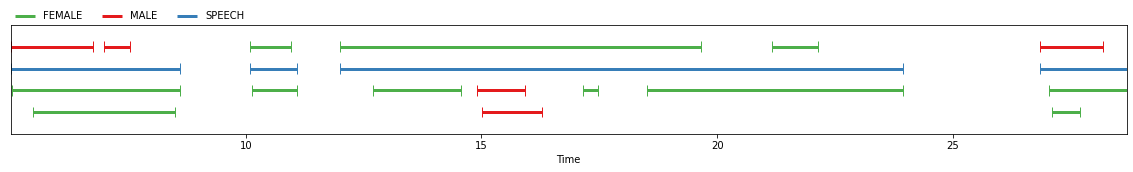

In [4]:
from pyannote.core import notebook
notebook.crop = reference.get_timeline().extent()
reference

## Training

We initialize a multilabeling *task* that describes how the model will be trained:

* `vtc_debug` indicates that we will use files available in `vtc_debug.train()`.
* `duration=2.` and `batch_size=128` indicates that the model will ingest batches of 128 two seconds long audio chunks.

In [5]:
from pyannote.audio import tasks

vtc_task = tasks.MultilabelDetection(vtc_debug, duration=2., batch_size=128)

Protocol Debug.SpeakerDiarization.Debug does not precompute the output of torchaudio.info(): adding a 'torchaudio.info' preprocessor for you to speed up dataloaders. See pyannote.database documentation on how to do that yourself.


We initialize one *model* with the `PyanNet` architecture used [in that paper](https://arxiv.org/abs/2104.04045).  
In particular, we increase the default stride of the initial `sincnet` feature extraction layer to `10`.

The model is also provided with the task (`task=vad`) for which it is being trained:

In [6]:
from pyannote.audio.models.segmentation import PyanNet

model = PyanNet(task=vtc_task)

Now that everything is ready, let's train with `pytorch-ligthning`!

In [7]:
import pytorch_lightning as pl

trainer = pl.Trainer(gpus=1, max_epochs=20)
trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type             | Params | In sizes        | Out sizes                                        
-----------------------------------------------------------------------------------------------------------------------------
0 | sincnet           | SincNet          | 42.6 K | [128, 1, 32000] | [128, 60, 115]                                   
1 | lstm              | LSTM             | 589 K  | [128, 115, 60]  | [[128, 115, 256], [[4, 128, 128], [4, 128, 128]]]
2 | linear            | ModuleList       | 49.4 K | ?               | ?                                                
3 | classifier        | Linear           | 387    | [128, 115, 128] | [128, 115, 3]                                    
4 | activation        | Sigmoid          | 0      | [128, 115, 3]   | [128, 115, 3]                                    
5 

Epoch 0:  50%|█████████████████████████████████████████████████████████████████████████                                                                         | 1/2 [00:10<00:10, 10.15s/it, loss=0.694, v_num=5]
Validating: 0it [00:00, ?it/s]
Epoch 1:  50%|█████████         | 1/2 [00:10<00:10, 10.20s/it, loss=0.695, v_num=5, MultilabelDetection-DebugSpeakerDiarizationDebug-AUROC=0.358, MultilabelDetection-DebugSpeakerDiarizationDebug-TrainLoss=0.694]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|█████████         | 1/2 [00:10<00:10, 10.30s/it, loss=0.693, v_num=5, MultilabelDetection-DebugSpeakerDiarizationDebug-AUROC=0.350, MultilabelDetection-DebugSpeakerDiarizationDebug-TrainLoss=0.696]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|█████████         | 1/2 [00:10<00:10, 10.62s/it, loss=0.692, v_num=5, MultilabelDetection-DebugSpeakerDiarizationDebug-AUROC=0.342, MultilabelDetection-DebugSpeakerDiarizationDebug-TrainLoss=0.690]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|█████████▌    

For the purpose of this tutorial, the model is trained for only 2 epochs. One can obviously expect better performance by training longer and on more data.

See [`pytorch-lightning`](https://www.pytorchlightning.ai/) documentation to learn more about the [`Trainer` API](https://pytorch-lightning.readthedocs.io/en/latest/common/trainer.html), in particular.

## Inference

Once trained, the model can be applied to a test file:

In [8]:
test_file = next(vtc_debug.test())
# here we use a test file provided by the protocol, but it could be any audio file
# e.g. test_file = "/path/to/test.wav".

Because the model was trained on 2s audio chunks and that test files are likely to be much longer than that, we wrap the `model` with an `Inference` instance: it will take care of sliding a 2s window over the whole file and aggregate the output of the model.

In [9]:
from pyannote.audio import Inference

inference = Inference(model)
labels_probability = inference(test_file)

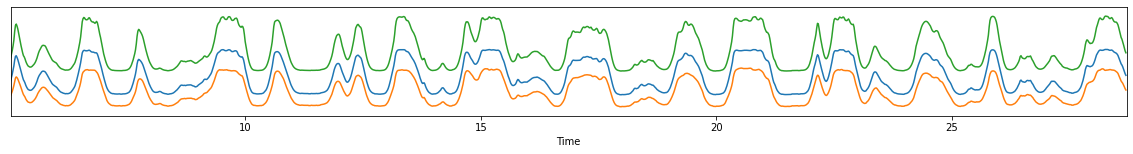

In [10]:
labels_probability

Perfect voice type classification output should look like that:

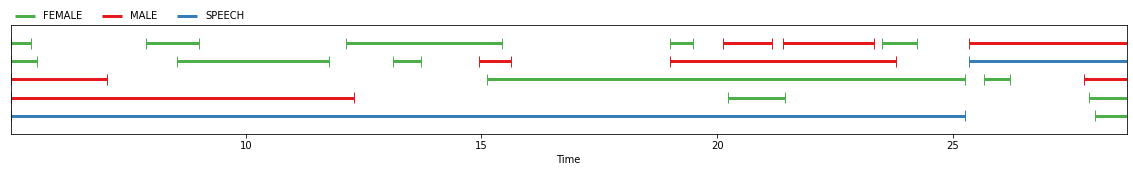

In [11]:
expected_output = test_file["annotation"]
expected_output

## Pipeline

Almost there! To obtain the final speech regions, we need to apply a detection threshold.  
For that, we rely on the voice activity detection pipeline whose hyper-parameters are set manually:
- `onset=0.6`: mark region as `active` when probability goes above 0.6
- `offset=0.4`: switch back to `inactive` when probability goes below 0.4
- `min_duration_on=0.0`: remove `active` regions shorter than that many seconds
- `min_duration_off=0.0`: fill `inactive` regions shorter than that many seconds


More details about those hyper-parameters are provided in Figure 2 of [that paper](https://arxiv.org/abs/2104.04045).

In [12]:
from pyannote.audio import pipelines

pipeline = pipelines.MultilabelDetection(segmentation=model)
initial_params = {"thresholds" : {class_label: {"onset": 0.1, "offset": 0.3,
                                "min_duration_on": 0.0, "min_duration_off": 0.0}
                  for class_label in pipeline.classes()}}
pipeline.instantiate(initial_params)

Here we go:

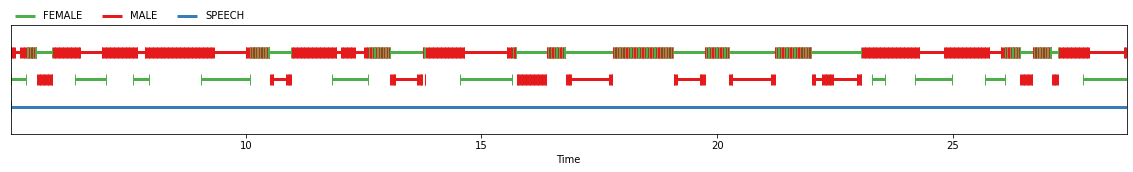

In [13]:
pipeline(test_file)

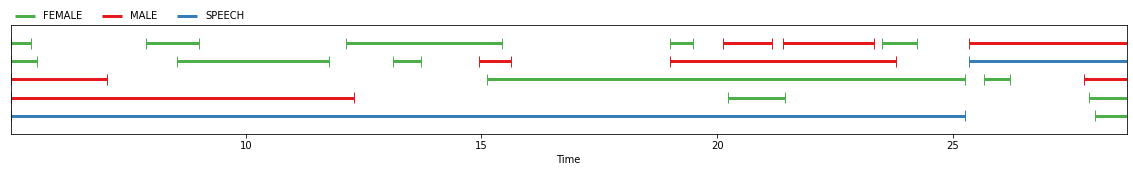

In [14]:
expected_output

That doesn't look too good... Let's perform a proper evaluation by computing the [identification error rate](https://pyannote.github.io/pyannote-metrics/reference.html#identification) over the whole AMI test set:

In [15]:
from pyannote.metrics.identification import IdentificationErrorRate

metric = IdentificationErrorRate()

for file in vtc_debug.test():
    # apply the voice activity detection pipeline
    speech = pipeline(file)

    # evaluate its output
    _ = metric(
        file['annotation'],  # this is the reference annotation
        speech,  # this is the hypothesized annotation
        uem=file['annotated'])  # this is the part of the file that should be evaluated

# aggregate the performance over the whole test set
identification_error_rate = abs(metric)
print(f'Identification error rate = {identification_error_rate * 100:.1f}%')

Identification error rate = 89.3%


## Optimizing pipeline hyper-parameters

This definitely can be improved by tweaking the hyper parameters we chose manually. We can try to optimize `onset` and `offset` on the development (a.k.a. validation) set to get better performance (and freeze the other two hyper-parameters).

In [16]:
for label in pipeline.classes():
    pipeline.freeze({ 'thresholds' : {label: {'min_duration_on': 0.0, 'min_duration_off': 0.0}}})

In [20]:
from pyannote.pipeline import Optimizer

optimizer = Optimizer(pipeline)
optimizer.tune(list(vtc_debug.development()),
               warm_start=initial_params,
               n_iterations=20,
               show_progress=False)

optimized_params = optimizer.best_params

There you go: better hyper-parameters that (should) lead to better results!

In [21]:
print(optimized_params)

{'thresholds': {'FEMALE': {'onset': 0.2762262714267786, 'offset': 0.9798229253459947, 'min_duration_on': 0.0, 'min_duration_off': 0.0}, 'MALE': {'onset': 0.3088367514785873, 'offset': 0.13976803343959915, 'min_duration_on': 0.0, 'min_duration_off': 0.0}, 'SPEECH': {'onset': 0.2937265788324095, 'offset': 0.639752173482726, 'min_duration_on': 0.0, 'min_duration_off': 0.0}}}


Let's evaluate the voice activity detection pipeline with this new set of hyper-parameters:

In [22]:
optimized_pipeline = pipeline.instantiate(optimized_params)

metric = IdentificationErrorRate()

for file in vtc_debug.test():
    speech = optimized_pipeline(file)
    _ = metric(file['annotation'], speech, uem=file['annotated'])

identification_error_rate = abs(metric)
print(f'Identification error rate = {identification_error_rate * 100:.1f}%')

Identification error rate = 91.0%


🎉 Yeay! 5% relativement improvement simply by tuning the thresholds.